# Phase 1- Summarizing Terms and Conditions
### Group No.: 23

## Importing Libraries and Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Declaring constants
DATA_DIR = '/content/drive/MyDrive/contract-nli'

In [ ]:
# Opening JSON file
file_data = open(DATA_DIR + '/train.json')
data = json.load(file_data)

## Exploring the data

In [ ]:
# Data consists of documents and labels
for key, value in data.items():
    print('Types of document: ', key,', Number of documents: ', len(value))

Types of document:  documents , Number of documents:  423
Types of document:  labels , Number of documents:  17


In [ ]:
# Dataset main
main_df = pd.DataFrame(data['documents'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [ ]:
# Dataset labels
labels_df = pd.DataFrame(data['labels'])
labels_df.head()

,nda-11,nda-16,nda-15,nda-10,nda-2,nda-1,nda-19,nda-12,nda-20,nda-3,nda-18,nda-7,nda-17,nda-8,nda-13,nda-5,nda-4
short_description,No reverse engineering,Return of confidential information,No licensing,Confidentiality of Agreement,None-inclusion of non-technical information,Explicit identification,Survival of obligations,Permissible development of similar information,Permissible post-agreement possession,Inclusion of verbally conveyed information,No solicitation,Sharing with third-parties,Permissible copy,Notice on compelled disclosure,Permissible acquirement of similar information,Sharing with employees,Limited use
hypothesis,Receiving Party shall not reverse engineer any...,Receiving Party shall destroy or return some C...,Agreement shall not grant Receiving Party any ...,Receiving Party shall not disclose the fact th...,Confidential Information shall only include te...,All Confidential Information shall be expressl...,Some obligations of Agreement may survive term...,Receiving Party may independently develop info...,Receiving Party may retain some Confidential I...,Confidential Information may include verbally ...,Receiving Party shall not solicit some of Disc...,Receiving Party may share some Confidential In...,Receiving Party may create a copy of some Conf...,Receiving Party shall notify Disclosing Party ...,Receiving Party may acquire information simila...,Receiving Party may share some Confidential In...,Receiving Party shall not use any Confidential...


## Cleaning Dataset

### To start our cleaning and pre-processing steps, we first:
#### 1. Remove NULL values
#### 2. Remove any Duplicate values from the dataset

In [ ]:
# Null values removal
main_df.isnull().sum()

id                 0
file_name          0
text               0
spans              0
annotation_sets    0
document_type      0
url                0
dtype: int64

In [ ]:
# Duplicate documents removal
duplicate_exists = main_df['id'].duplicated()
duplicate_exists

0      False
1      False
2      False
3      False
4      False
       ...  
418    False
419    False
420    False
421    False
422    False
Name: id, Length: 423, dtype: bool

## Adding/Updating important columns in dataset-
### 1. `annotations_sets` - making it into a dictionary
### 2. `annotations_new` - aggregating all annotations for text

In [ ]:
# Getting rid of nested annotations
main_df['annotation_sets'] = main_df['annotation_sets'].apply(lambda x: x[0]['annotations'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [ ]:
# Important function- Accessing text using spans and accessing spans using annotation sets
def get_all_annotations_for_text(spans, annotation_sets, text):
    temp_di = {}
    for key, value in annotation_sets.items():
        annotation_span_new = []
        for annotation_span in value['spans']:
            annotation_span_new.append(text[spans[annotation_span][0]:spans[annotation_span][1]])
        temp_di[key] = {'choice': value['choice'], 'spans': annotation_span_new}
    return temp_di

In [ ]:
main_df['annotations_new'] = main_df.apply(lambda x: get_all_annotations_for_text(x.spans, x.annotation_sets, x.text), axis=1)
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url,annotations_new
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."


### Getting Data ready for Tokization and Stop Words removal by generating `Text` to `NDA` Mapping

In [ ]:
# Function to get the text to respective nda mapping
def get_text_to_nda_mapping(main_df):
    text_nda_list = []
    for annotation_item in main_df['annotations_new']:
        for key, value in annotation_item.items():
            if value['spans']:
                for span in value['spans']:
                    text_nda_list.append({'text': span, 'nda': key, 'choice': value['choice']})
            else:
                text_nda_list.append({'text': '', 'choice': value['choice'], 'nda': key})
    return pd.DataFrame(text_nda_list)

text_nda_df = get_text_to_nda_mapping(main_df)
text_nda_df.head()

,text,choice,nda
0,,NotMentioned,nda-11
1,5. All Confidential Information in any form an...,Entailment,nda-16
2,(a) if a business relationship is not entered ...,Entailment,nda-16
3,4. Nothing in this Agreement is to be construe...,Entailment,nda-15
4,11. The Recipient shall not advertise or other...,Entailment,nda-10


## Text Preprocessing
### 1. Group all text based on nda
### 2. Tokenization
### 3. Stop words, Punctuations, Links removal

In [ ]:
text_nda_df['text']= text_nda_df[['text', 'nda']].groupby(['nda'])['text'].transform(lambda x: ','.join(x))
nda_aggregated_text_df = text_nda_df[['text', 'nda']].drop_duplicates()
nda_aggregated_text_df

,text,nda
0,",,,,,IV. NO REVERSE ENGINEERING; WORK PRODUCT:...",nda-11
1,5. All Confidential Information in any form an...,nda-16
3,4. Nothing in this Agreement is to be construe...,nda-15
4,11. The Recipient shall not advertise or other...,nda-10
5,",“Confidential Information” means any Idea dis...",nda-2
6,"1. “Confidential Information”, whenever used i...",nda-1
7,Either Party may terminate the working relatio...,nda-19
8,The Recipient shall not be precluded from disc...,nda-12
10,",At Organiser’s first request, Mentor shall:,(...",nda-20
11,"1. “Confidential Information”, whenever used i...",nda-3


In [ ]:
nda_text_dict = nda_aggregated_text_df.set_index('nda')['text'].to_dict()
nda_data = []
for key,value in nda_text_dict.items():
    nda_data.append({'nda':key, 'text':value})

In [ ]:
stopwords = set(stopwords.words('english'))

def process_text(text, nda_id):
    word_list = []
    for i, raw_text in enumerate(text):
        # Removing white spaces
        word_list.append(raw_text.strip()) 
    for i, word in enumerate(word_list):
        if word == '':
            word_list.remove(word)
        # Rule: Words should start with alphabets
        elif word[0].isalpha() == False: 
            word_list.remove(word)
    
    new_list = []
    for i, word in enumerate(word_list):
        temp = word.split(" ")
        for word in temp:
            # Removing Empty Strings, Numbers and Hyperlinks
            if word == "" or word == '' or word.isnumeric() == True or word[0:5] == "https": 
                break

            # Removing Punctuations
            if word[0].isalpha() == False: 
                word = word[1:]
            elif word[-1].isalpha() == False:
                word = word[:-1]
            
            # Convert all text to lower case
            if len(word) != 0:
                new_list.append(word.lower()) 
    
    processed_text_list = []
    for word in new_list:
        if word not in stopwords:
            processed_text_list.append(word)
    
    term_count = {}
    term_count['nda'] = nda_id
    words_so_far = []
    for i, j in enumerate(processed_text_list):
        if j != "class" and j != "nda":
            if j not in words_so_far:
                term_count[j] = 1
                words_so_far.append(j)
            else:
                term_count[j] += 1
    return term_count

def get_term_counts(input_data):
    term_count_list = []
    for idx, raw_text in enumerate(input_data):
        text = raw_text['text'].split(" ")
        tokenized_text = process_text(text, raw_text['nda'])
        term_count_list.append(tokenized_text)
    return term_count_list

term_counts = get_term_counts(nda_data)

### Finding top 10 keywords for every NDA

In [ ]:
sorted_term_counts_list = []

for i, nda_term_dict in enumerate(term_counts):
    nda_number = nda_term_dict['nda']
    del nda_term_dict['nda']
    sorted_term_counts_list.append(dict(sorted(nda_term_dict.items(), key = lambda x: x[1], reverse = True)[:10]))
    sorted_term_counts_list[i]['nda'] = nda_number

sorted_term_counts_list

[{'party': 63,
  'information': 63,
  'reverse': 59,
  'confidential': 55,
  'engineer': 42,
  'shall': 34,
  'disassemble': 33,
  'decompile': 30,
  'receiving': 27,
  'software': 25,
  'nda': 'nda-11'},
 {'party': 280,
  'information': 247,
  'confidential': 183,
  'shall': 155,
  'disclosing': 140,
  'upon': 137,
  'copies': 136,
  'return': 124,
  'agreement': 118,
  'termination': 114,
  'nda': 'nda-16'},
 {'information': 618,
  'party': 510,
  'confidential': 468,
  'shall': 407,
  'property': 366,
  'rights': 324,
  'disclosing': 282,
  'agreement': 280,
  'right': 210,
  'license': 194,
  'nda': 'nda-15'},
 {'party': 244,
  'information': 202,
  'discussions': 153,
  'agreement': 137,
  'transaction': 123,
  'parties': 112,
  'terms': 110,
  'without': 108,
  'confidential': 105,
  'written': 99,
  'nda': 'nda-10'},
 {'information': 1288,
  'business': 428,
  'party': 381,
  'confidential': 340,
  'data': 277,
  'plans': 271,
  'financial': 231,
  'including': 227,
  'disclosin

In [ ]:
sorted_term_counts_list[0]['nda']

'nda-11'

## Visualization-
### As a part of our EDA, we visualize:
#### 1. Bar Graph - The `NDA` Count Bar Graph which gives us the most common nda found in documents
#### 2. Pie Chart - The proportion of each `NLI Label` in the dataset

In [ ]:
# Get respective counts of nda for each Document
def get_document_nda_counts():
    document_annotations = {}

    for document in data['documents']:
        temp_annotations = {}
        for key, value in document['annotation_sets'][0]['annotations'].items():
            temp_annotations[key] = len(value['spans'])
        document_annotations[document['id']] = temp_annotations

    return document_annotations

# Get Aggregated counts of nda for document 
def get_total_nda_counts(document_annotations):
  nda_counts_dict = {}

  for key, value in document_annotations.items():
    for nda, nda_count in value.items():
        if nda not in nda_counts_dict:
            nda_counts_dict[nda] = nda_count
        else:
            nda_counts_dict[nda] += nda_count

  return nda_counts_dict

# Plot nda counts
def plot_nda_counts_bar(nda_counts_dict):
    sorted_nda=dict(sorted(nda_counts_dict.items(), key = lambda item: item[1], reverse = True))
    plt.subplots(figsize=(15,10))
    plt.bar(range(len(sorted_nda)), list(sorted_nda.values()))
    plt.xticks(range(len(sorted_nda)), list(sorted_nda.keys()))
    plt.title("NDA Vs Frequency")
    plt.xlabel("NDA")
    plt.ylabel("Frequency")
    for i, v in enumerate(sorted_nda.values()):
        plt.text(i, v + 3, str(v), ha='center')
    plt.show()

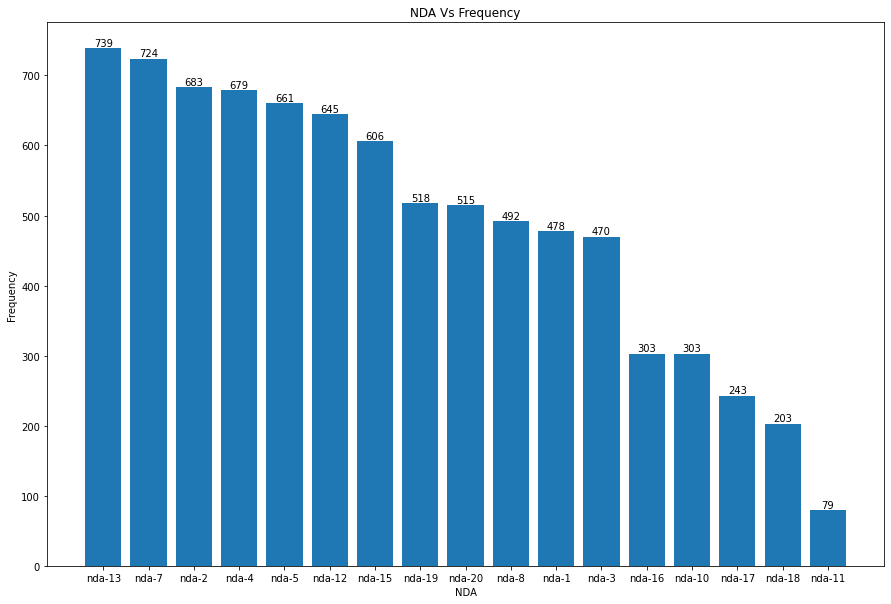

In [ ]:
document_annotations = get_document_nda_counts()
nda_counts = get_total_nda_counts(document_annotations)
plot_nda_counts_bar(nda_counts)

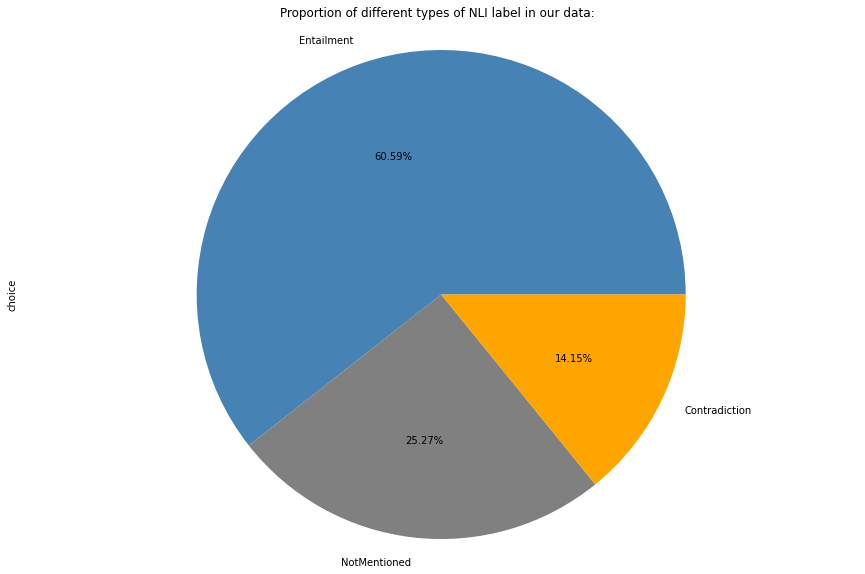

In [ ]:
# NLI label pie chart
def plot_nli_label_pie(text_nda_df):
    plt.subplots(figsize=(15,10))
    text_nda_df['choice'].value_counts().plot.pie(colors = ['Steelblue', 'Gray', 'orange'], autopct='%1.2f%%')
    plt.axis('equal')
    plt.title("Proportion of different types of NLI label in our data: ")
    plt.show()

plot_nli_label_pie(text_nda_df)

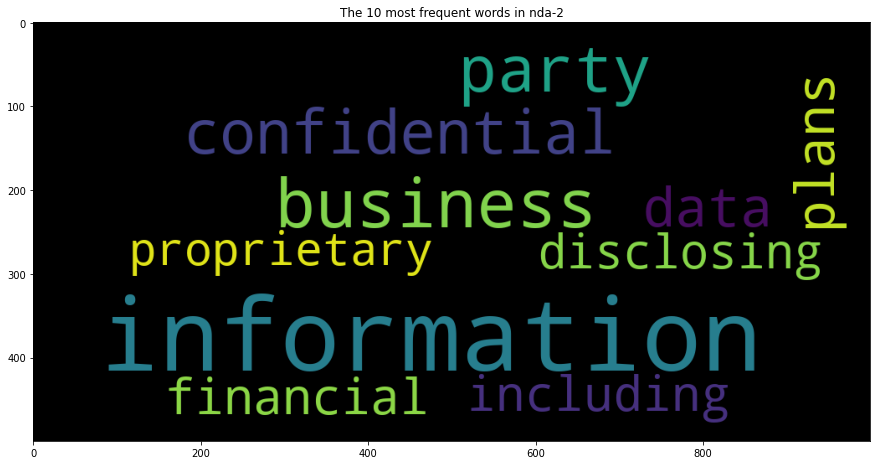

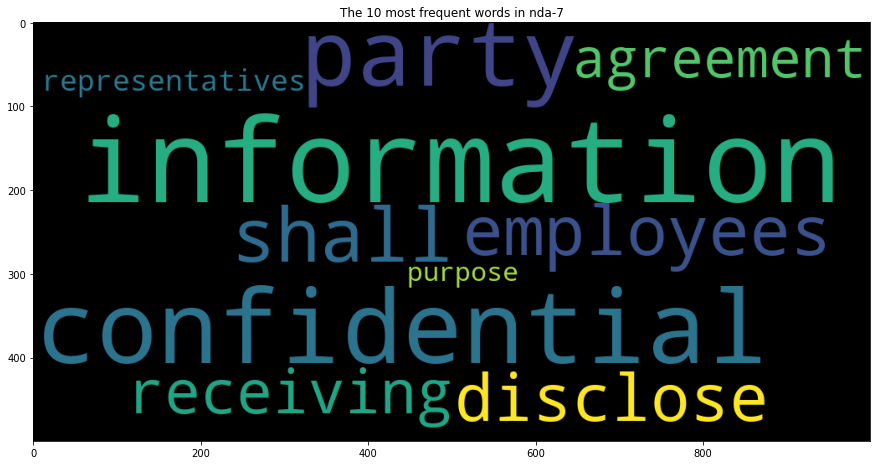

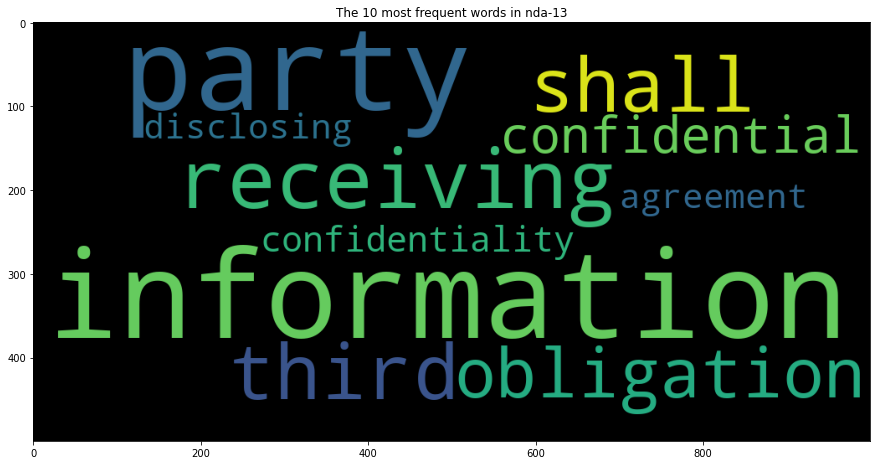

In [ ]:
#plotting the 10 most frequent words in three of the most common NDAs
from wordcloud import WordCloud

sorted_nda_counts = dict(sorted(nda_counts.items(), key=lambda item: item[1], reverse=True))
top_three_nda_counts = [key for key, value in list(sorted_nda_counts.items())[:3]]

#top_three_nda_counts

for i in range(len(sorted_term_counts_list)):
  if(sorted_term_counts_list[i]['nda'] in top_three_nda_counts):
    n = sorted_term_counts_list[i]['nda']
    del sorted_term_counts_list[i]['nda']
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(sorted_term_counts_list[i])
    plt.figure(figsize=(15,10))
    plt.title("The 10 most frequent words in "+ n)
    plt.imshow(wordcloud)

These singular words are repeatitive and do not provide much context. Let's try some bi-grams and tri-grams to get a clearer understanding of the context within the nda-text

To build a representation of our vocabulary we will use Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. 

In [ ]:
from nltk.util import ngrams
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def Convert(string):
    li = list(string.split(" "))
    return li

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# Code Snippet for Top N-grams Barchart
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(15,10))
    sns.barplot(x=y,y=x)

In [ ]:
#Look at the text
nda_aggregated_text_df['text']

0     ,,,,,IV. NO REVERSE ENGINEERING; WORK PRODUCT:...
1     5. All Confidential Information in any form an...
3     4. Nothing in this Agreement is to be construe...
4     11. The Recipient shall not advertise or other...
5     ,“Confidential Information” means any Idea dis...
6     1. “Confidential Information”, whenever used i...
7     Either Party may terminate the working relatio...
8     The Recipient shall not be precluded from disc...
10    ,At Organiser’s first request, Mentor shall:,(...
11    1. “Confidential Information”, whenever used i...
12    ,,,,,V. NON-SOLICITATION OF EMPLOYEES AND/OR C...
13    2.3 Provided that the Recipient has a written ...
15    The Recipient will not copy or reproduce the C...
16    The Recipient may disclose the Confidential In...
17    The Recipient shall not be precluded from disc...
19    2.3 Provided that the Recipient has a written ...
22    The Recipient shall use the Confidential Infor...
Name: text, dtype: object

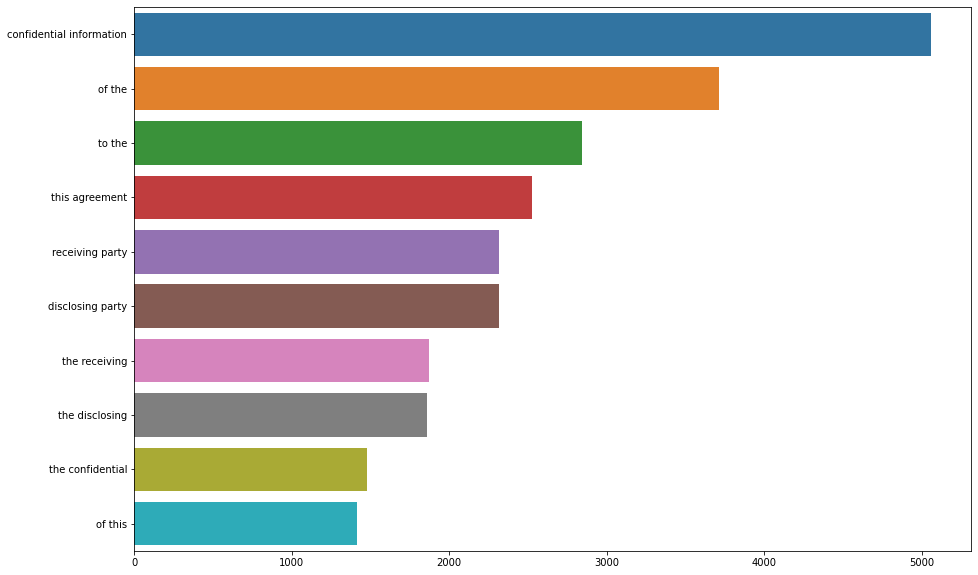

In [ ]:
plot_top_ngrams_barchart(nda_aggregated_text_df['text'],2)

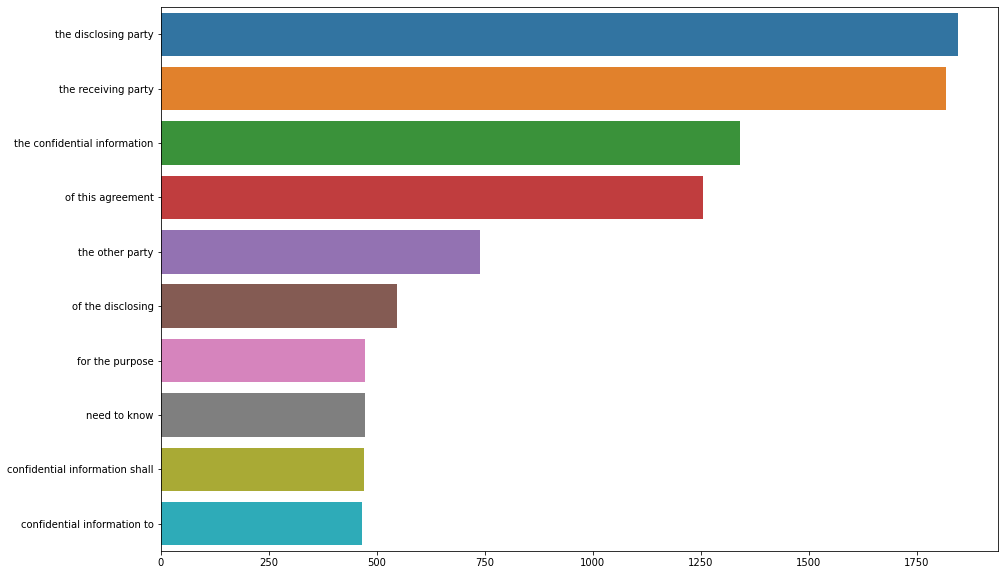

In [ ]:
plot_top_ngrams_barchart(nda_aggregated_text_df['text'],3)

Now, let's try creating an exciting dynamic visualization using Topic modeling (LDA)

**Topic modeling** is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.

But before getting into topic modeling we have to pre-process our data a little. We will:

- tokenize: the process by which sentences are converted to a list of tokens or words.
- remove stopwords
- lemmatize: reduces the inflectional forms of each word into a common base or root.
- convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.


With NLTK you can tokenize and lemmatize easily

In [ ]:
import pyLDAvis.gensim_models
import nltk
from gensim.models import LdaMulticore
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(nda_aggregated_text_df['text'])

In [ ]:
lda_model.show_topics()

[(0,
  '0.031*"Information" + 0.030*"Party" + 0.027*"Confidential" + 0.027*"copy" + 0.024*"shall" + 0.018*"party" + 0.017*"request" + 0.016*"Disclosing" + 0.015*"return" + 0.012*"upon"'),
 (1,
  '0.044*"information" + 0.022*"Information" + 0.021*"Party" + 0.020*"Confidential" + 0.014*"business" + 0.014*"confidential" + 0.012*"including" + 0.011*"disclosed" + 0.011*"party" + 0.010*"Disclosing"'),
 (2,
  '0.041*"Information" + 0.040*"shall" + 0.036*"Confidential" + 0.024*"Agreement" + 0.023*"Party" + 0.019*"party" + 0.018*"use" + 0.013*"purpose" + 0.013*"The" + 0.011*"right"'),
 (3,
  '0.032*"Information" + 0.028*"Party" + 0.028*"Confidential" + 0.024*"party" + 0.022*"information" + 0.021*"shall" + 0.014*"Recipient" + 0.013*"Receiving" + 0.013*"disclose" + 0.013*"employee"')]

In [ ]:
plot_lda_vis(lda_model, bow_corpus, dic)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.007856 -0.107271       1        1  42.449839
1     -0.148955  0.031193       2        1  29.147811
2      0.069578 -0.024651       3        1  17.735611
0      0.071522  0.100729       4        1  10.666740, topic_info=                 Term         Freq        Total Category  logprob  loglift
379             shall  3762.000000  3762.000000  Default  30.0000  30.0000
150              copy   873.000000   873.000000  Default  29.0000  29.0000
42        Information  5384.000000  5384.000000  Default  28.0000  28.0000
27       Confidential  4674.000000  4674.000000  Default  27.0000  27.0000
1132          request   543.000000   543.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
332          provided   127.936403  1084.275535   Topic4  -4.9826   0.1009
222              form   111.139611   684.617652   Topic4  -5.1233   0.4200
250       information   131.891319  4179.894109   Topic4  -4.9521  -1.2180
68    Representatives   113.955896  1144.661941   Topic4  -5.0983  -0.0690
24            Company    99.457447   797.603106   Topic4  -5.2344   0.1562

[359 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
445       3  0.114101     ,At
445       4  0.912809     ,At
456       3  0.134004   ,Upon
456       4  0.848692   ,Upon
477       4  0.856032   After
...     ...       ...     ...
434       1  0.341941    year
434       2  0.011526    year
434       3  0.630094    year
434       4  0.015368    year
4063      3  0.931489  years.

[788 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

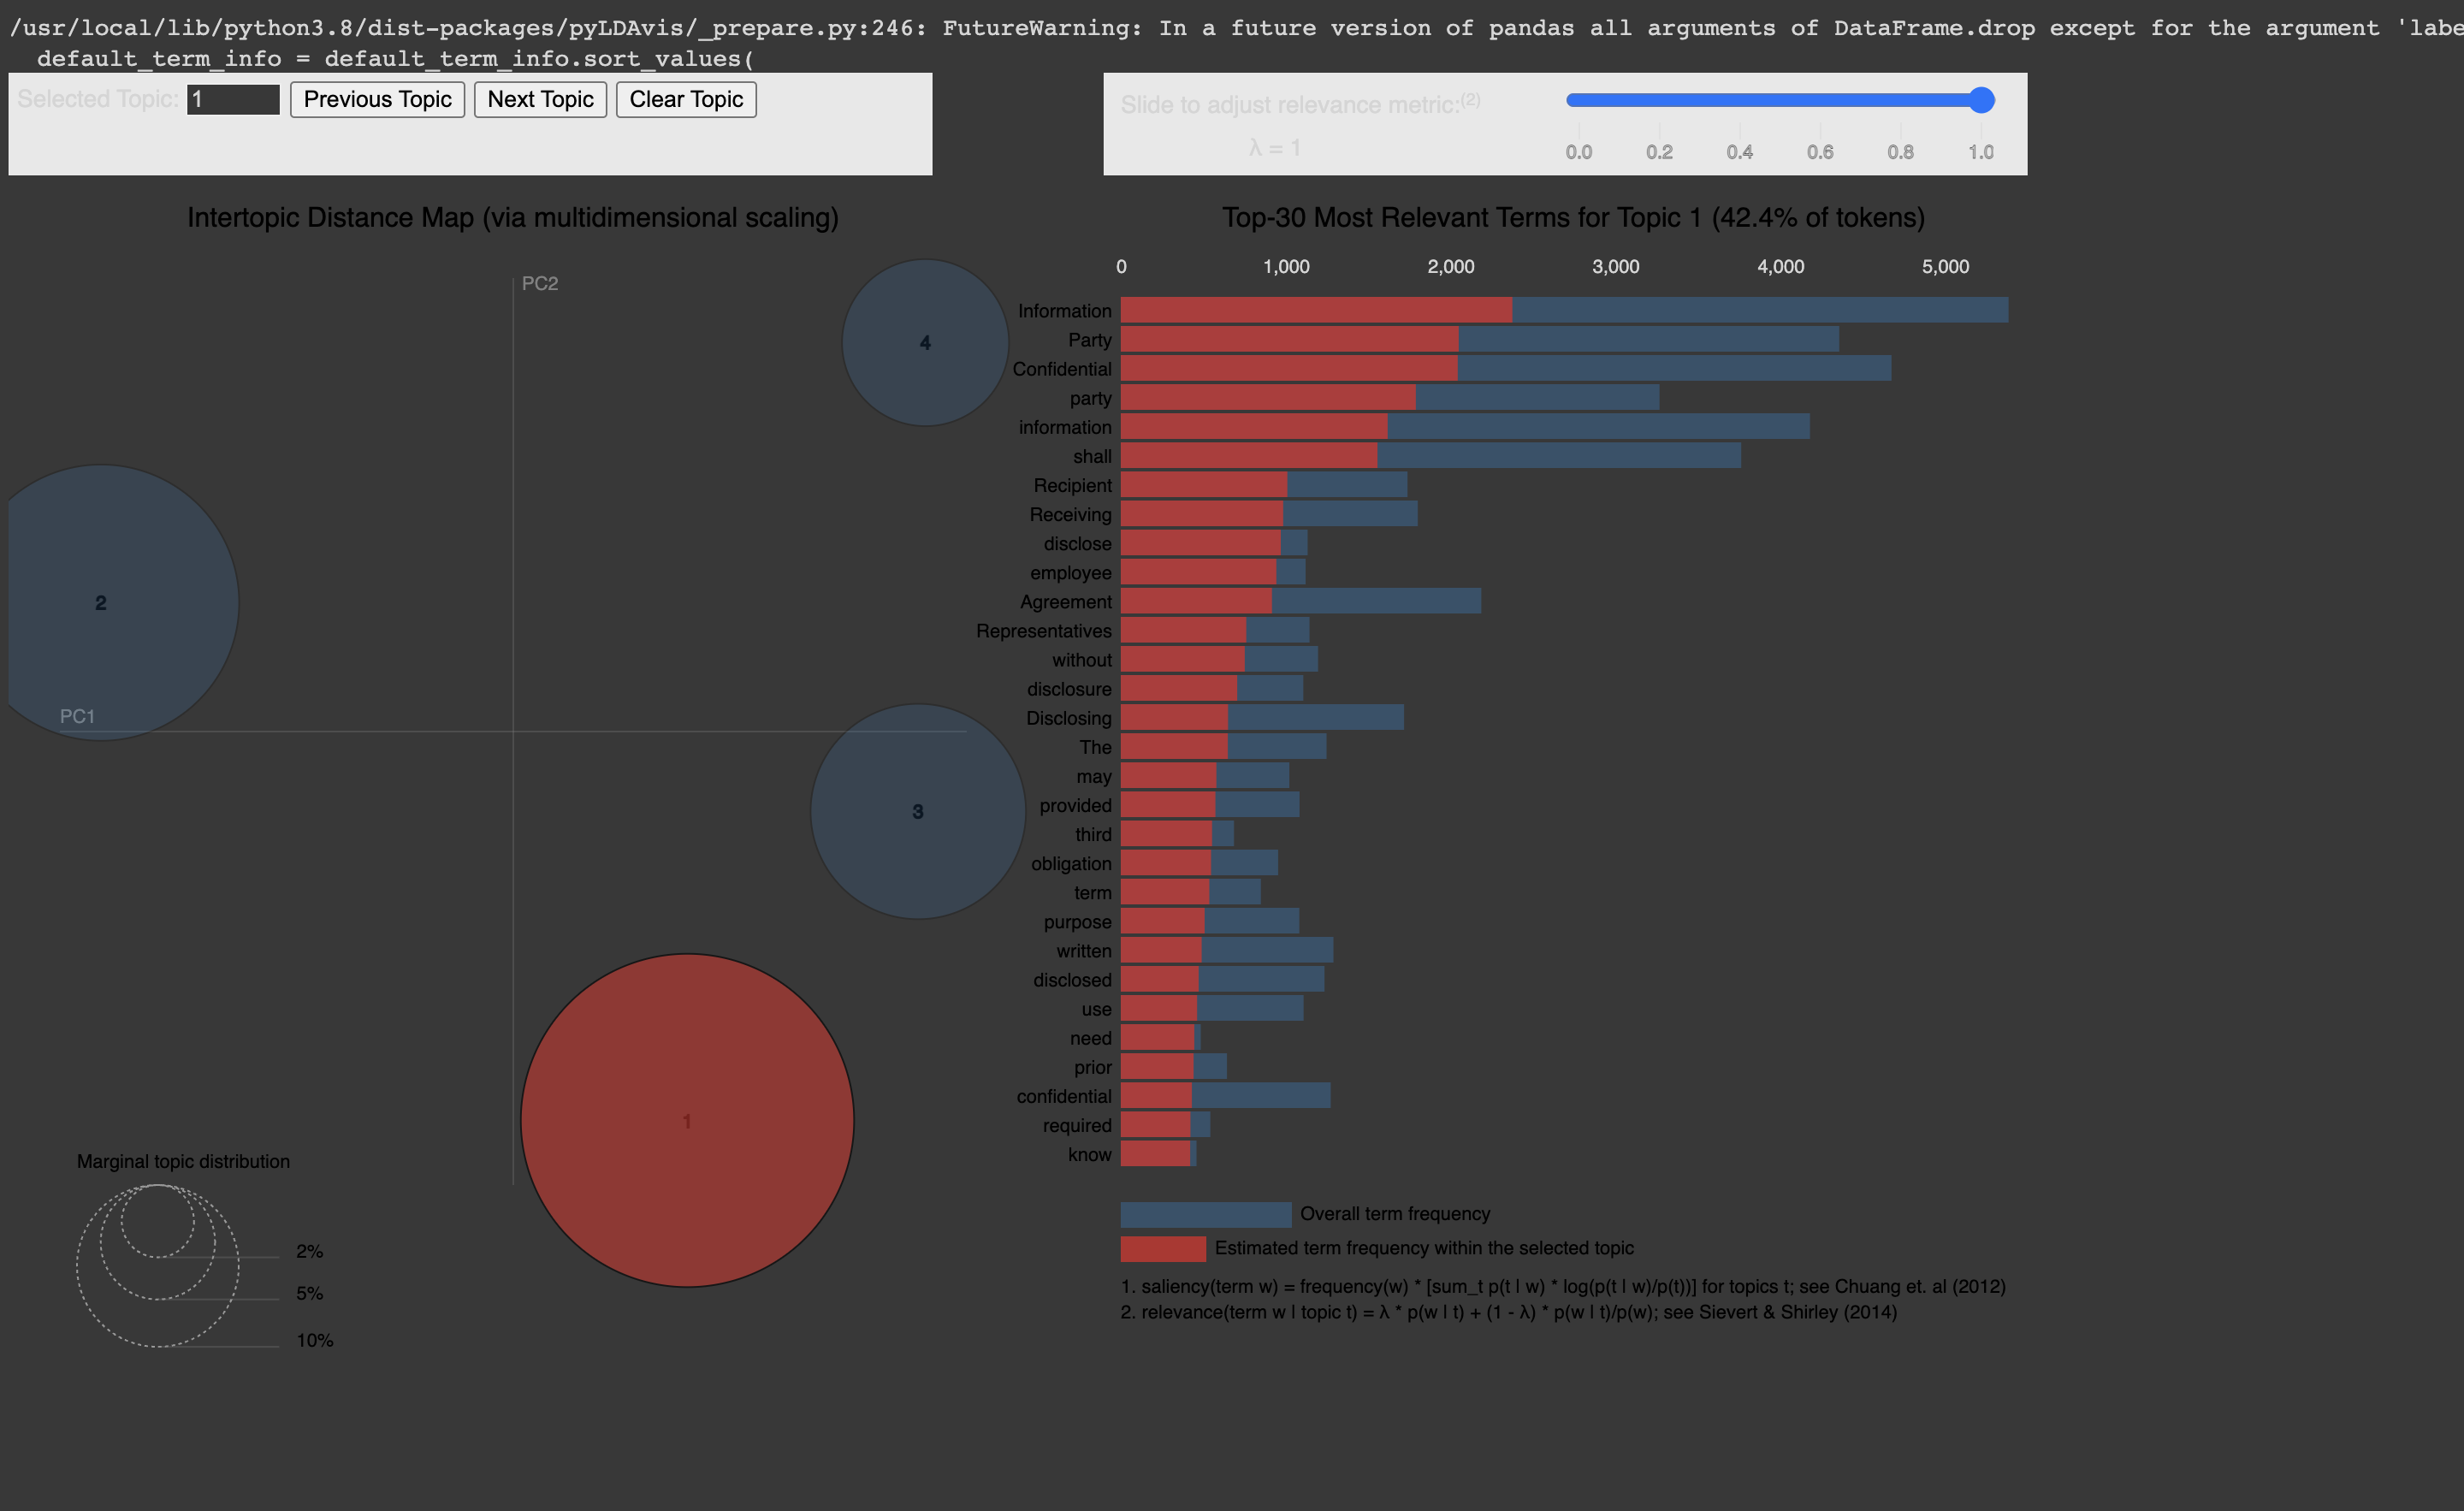